# HEOM 1d: Spin-Bath model, fitting of spectrum and correlation functions

## Introduction

The HEOM method solves the dynamics and steady state of a system and its environment, the latter of which is encoded 
in a set of auxiliary density matrices.

In this example we show the evolution of a single two-level system in contact with a single bosonic environment.

The properties of the system are encoded in Hamiltonian, and a coupling operator which describes how it is coupled to the environment.

The bosonic environment is implicitly assumed to obey a particular Hamiltonian ([see paper](https://arxiv.org/abs/2010.10806)), the parameters of which are encoded in the spectral density, and subsequently the free-bath correlation functions.

In the example below we show how to model an Ohmic environment with exponential cut-off in three ways:

* First we fit the spectral density with a set of underdamped brownian oscillator functions.
* Second, we evaluate the correlation functions, and fit those with a certain choice of exponential functions.
* Third, we use the available OhmicBath class 

In each case we will use the fit parameters to determine the correlation function expansion co-efficients needed to construct a description of the bath (i.e. a `BosonicBath` object) to supply to the `HEOMSolver` so that we can solve for the system dynamics.

## Setup

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import qutip
from qutip import (
    basis,
    expect,
    sigmax,
    sigmaz,
)
from qutip.solver.heom import (
    HEOMSolver,
    SpectralFitter,
    CorrelationFitter,
    OhmicBath,
)

# Import mpmath functions for evaluation of gamma and zeta
# functions in the expression for the correlation:

from mpmath import mp

mp.dps = 15
mp.pretty = True

%matplotlib inline

In [2]:
# Solver options:

options = {
    "nsteps": 15000,
    "store_states": True,
    "rtol": 1e-14,
    "atol": 1e-14,
    "method": "vern9",
    "progress_bar": "enhanced",
}

## System and bath definition

And let us set up the system Hamiltonian, bath and system measurement operators:

### System Hamiltonian

In [3]:
# Defining the system Hamiltonian
eps = 0  # Energy of the 2-level system.
Del = 0.2  # Tunnelling term
Hsys = 0.5 * eps * sigmaz() + 0.5 * Del * sigmax()
rho0 = basis(2, 0) * basis(2, 0).dag()

### System measurement operators

In [4]:
# Define some operators with which we will measure the system
# 1,1 element of density matrix - corresonding to groundstate
P11p = basis(2, 0) * basis(2, 0).dag()
P22p = basis(2, 1) * basis(2, 1).dag()
# 1,2 element of density matrix  - corresonding to coherence
P12p = basis(2, 0) * basis(2, 1).dag()

### Analytical expressions for the Ohmic bath correlation function and spectral density

Before we begin fitting, let us examine the analytic expressions for the correlation and spectral density functions and write Python equivalents. 

The correlation function is given by (see, e.g., http://www1.itp.tu-berlin.de/brandes/public_html/publications/notes.pdf for a derivation, equation 7.59, but with a factor of $\pi$ moved into the definition of the correlation function):

\begin{align}
C(t) =& \: \frac{1}{\pi}\alpha \omega_{c}^{1 - s} \beta^{- (s + 1)} \: \times \\
      & \: \Gamma(s + 1) \left[ \zeta \left(s + 1, \frac{1 + \beta \omega_c - i \omega_c t}{\beta \omega_c}\right) + \zeta \left(s + 1, \frac{1 + i \omega_c t}{\beta \omega_c}\right) \right]
\end{align}

where $\Gamma$ is the Gamma function and

\begin{equation}
\zeta(z, u) \equiv \sum_{n=0}^{\infty} \frac{1}{(n + u)^z}, \; u \neq 0, -1, -2, \ldots
\end{equation}

is the generalized Zeta function. The Ohmic case is given by $s = 1$.

The corresponding spectral density for the Ohmic case is:

\begin{equation}
J(\omega) = \omega \alpha e^{- \frac{\omega}{\omega_c}}
\end{equation}

In [5]:
def ohmic_correlation(t, alpha, wc, beta, s=1):
    """The Ohmic bath correlation function as a function of t
    (and the bath parameters).
    """
    corr = (1 / np.pi) * alpha * wc ** (1 - s)
    corr *= beta ** (-(s + 1)) * mp.gamma(s + 1)
    z1_u = (1 + beta * wc - 1.0j * wc * t) / (beta * wc)
    z2_u = (1 + 1.0j * wc * t) / (beta * wc)
    # Note: the arguments to zeta should be in as high precision as possible.
    # See http://mpmath.org/doc/current/basics.html#providing-correct-input
    return np.array(
        [
            complex(corr * (mp.zeta(s + 1, u1) + mp.zeta(s + 1, u2)))
            for u1, u2 in zip(z1_u, z2_u)
        ],
        dtype=np.complex128,
    )

In [6]:
def ohmic_spectral_density(w, alpha, wc):
    """The Ohmic bath spectral density as a function of w
    (and the bath parameters).
    """
    return w * alpha * np.e ** (-w / wc)

In [7]:
def ohmic_power_spectrum(w, alpha, wc, beta):
    """The Ohmic bath power spectrum as a function of w
    (and the bath parameters).
    """
    bose = (1 / (np.e ** (w * beta) - 1)) + 1
    return w * alpha * np.e ** (-abs(w) / wc) * bose * 2

### Bath and HEOM parameters

Finally, let's set the bath parameters we will work with and write down some measurement operators:

In [8]:
Q = sigmaz()
alpha = 3.25
T = 0.5
wc = 1.0
s = 1

And set the cut-off for the HEOM hierarchy:

In [9]:
# HEOM parameters:

# The max_depth defaults to 5 so that the notebook executes more
# quickly. Change it to 11 to wait longer for more accurate results.
max_depth = 5

## Building the HEOM bath by fitting the spectral density

We begin by fitting the spectral density, using a series of $k$ underdamped harmonic oscillators case with the Meier-Tannor form (J. Chem. Phys. 111, 3365 (1999); https://doi.org/10.1063/1.479669):

\begin{equation}
J_{\mathrm approx}(\omega; a, b, c) = \sum_{i=0}^{k-1} \frac{2 a_i b_i w}{((w + c_i)^2 + b_i^2) ((w - c_i)^2 + b_i^2)}
\end{equation}

where $a, b$ and $c$ are the fit parameters and each is a vector of length $k$.

With the spectral density approximation $J_{\mathrm approx}(w; a, b, c)$ implemented above, we can now perform the fit and examine the results. This can be done quickly using the `SpectralFitter` class, which takes the target spectral density as an array and fits it to the series of **k** underdamped harmonic oscillators with the Meier-Tannor form

In [10]:
w = np.linspace(0, 15, 20000)
J = ohmic_spectral_density(w, alpha, wc)

We first initialize our SpectralFitter

In [11]:
fs = SpectralFitter(T, Q, w, J)

To obtain a fit we simply pass our desired spectral density and range, into the ``get_fit`` method. The number of exponents we'll use in our bath is given by Nk

In [12]:
bath, fitinfo = fs.get_fit(Nk=1)

To obtain an overview of the results of the fit we may take a look at the summary from the ``fitinfo``

In [13]:
print(fitinfo["summary"])

Result of fitting The Spectral Density with None terms: 
 
 Parameters|   lam    |  gamma   |   w0 
 1         | 2.39e+00 | 1.50e+00 |1.00e-01
 2         |-3.75e+00 | 4.31e+00 |4.17e+00
 3         | 5.37e+00 | 2.28e+00 |1.15e+00
 4         | 9.15e-02 | 6.03e-01 |1.00e-01
 5         | 1.18e-03 | 1.54e-01 |1.00e-01
 
A  normalized RMSE of  1.28e-06 was obtained for the The Spectral Density
 The current fit took  5.916326 seconds


We may see how the number of exponents chosen affects the fit since the approximated functions are available:

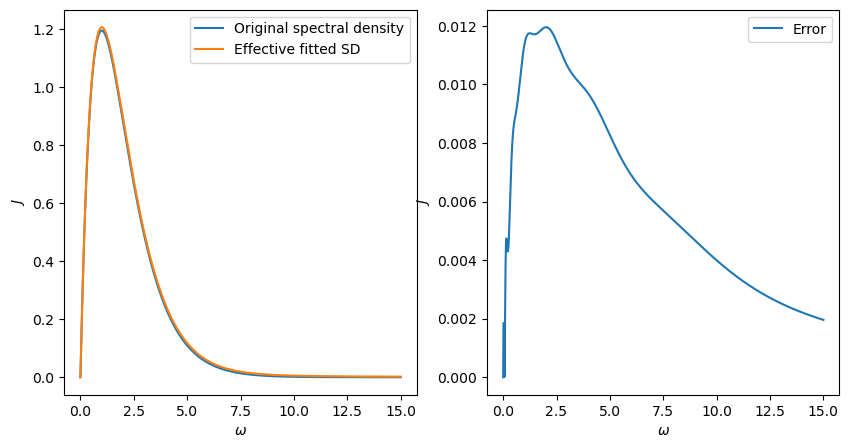

In [14]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

ax1.plot(w, J, label="Original spectral density")
ax1.plot(w, bath.spectral_density_approx(w), label="Effective fitted SD")
ax1.set_xlabel(r'$\omega$')
ax1.set_ylabel(r'$J$')
ax1.legend()

ax2.plot(w, np.abs(J - bath.spectral_density_approx(w)), label="Error")
ax2.set_xlabel(r'$\omega$')
ax2.set_ylabel(r'$J$')
ax2.legend()

plt.show()

Here we see a surprisingly large discrepancy in our approximated or effective spectral density. This happens because we are not using enough exponentials from each of the underdamped modes to have an appropiate fit. All modes have the same number of exponents, and we set it to 1 which is not enough to model a bath with the temperature considered, let us repeat this with a higher number of exponents.

Result of fitting The Spectral Density with None terms: 
 
 Parameters|   lam    |  gamma   |   w0 
 1         | 2.39e+00 | 1.50e+00 |1.00e-01
 2         |-3.75e+00 | 4.31e+00 |4.17e+00
 3         | 5.37e+00 | 2.28e+00 |1.15e+00
 4         | 9.15e-02 | 6.03e-01 |1.00e-01
 5         | 1.18e-03 | 1.54e-01 |1.00e-01
 
A  normalized RMSE of  1.28e-06 was obtained for the The Spectral Density
 The current fit took  6.213607 seconds


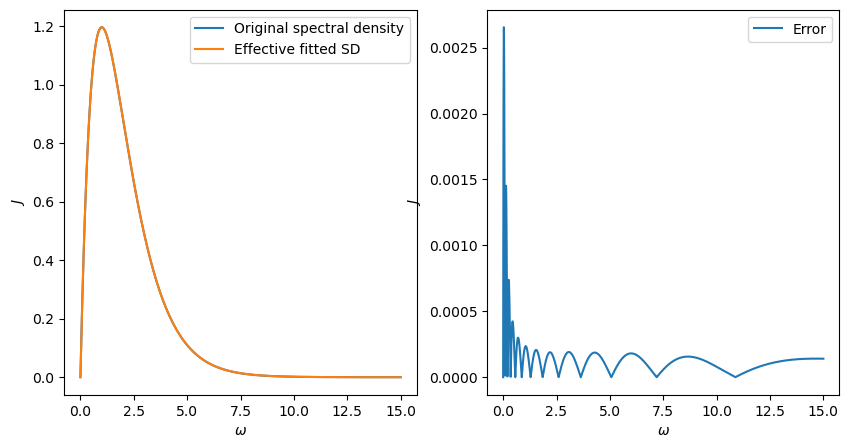

In [15]:
bath, fitinfo = fs.get_fit(Nk=5)
print(fitinfo["summary"])

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

ax1.plot(w, J, label="Original spectral density")
ax1.plot(w, bath.spectral_density_approx(w), label="Effective fitted SD")
ax1.set_xlabel(r'$\omega$')
ax1.set_ylabel(r'$J$')
ax1.legend()

ax2.plot(w, np.abs(J - bath.spectral_density_approx(w)), label="Error")
ax2.set_xlabel(r'$\omega$')
ax2.set_ylabel(r'$J$')
ax2.legend()

plt.show()

Since the number of exponents increases simulation time one should go with the least amount of exponents that correctly describe the bath properties (Power spectrum, Spectral density and the correlation function). When the number of exponents is not specified it defaults to 5.

By default the ``get_fit`` method, has a threshold normalized root mean squared error (NRMSE) of $5\times 10^{-6}$ and selects the number of oscillators automatically to obtain that value. One may also specify the number of oscillators that is used with the optional argument N, or may want a more accurate NRMSE, which can be specified with the final_rmse optional argument

In [16]:
bath, fitinfo = fs.get_fit(final_rmse=1e-6)
print(fitinfo["summary"])

Result of fitting The Spectral Density with None terms: 
 
 Parameters|   lam    |  gamma   |   w0 
 1         | 8.94e-01 | 1.15e+00 |1.10e-01
 2         | 1.87e-02 | 3.46e-01 |3.62e-01
 3         | 8.27e+00 | 5.41e+00 |1.00e-01
 4         | 7.69e+00 | 2.38e+00 |1.00e-01
 5         |-1.27e+01 | 4.92e+00 |2.77e+00
 6         | 1.52e-03 | 1.38e-01 |2.62e-01
 7         | 2.69e-03 | 1.74e-01 |1.00e-01
 
A  normalized RMSE of  8.05e-07 was obtained for the The Spectral Density
 The current fit took  52.747275 seconds


Alternatively one may choose the number of oscillators in the fit instead of a desired NRMSE

In [17]:
fittedbath, fitinfo = fs.get_fit(N=4)
print(fitinfo["summary"])

Result of fitting The Spectral Density with 4 terms: 
 
 Parameters|   lam    |  gamma   |   w0 
 1         | 1.56e+00 | 9.46e-01 |2.11e+00
 2         | 1.67e+00 | 9.17e-01 |1.13e+00
 3         | 1.00e+00 | 1.03e+00 |3.32e+00
 4         | 6.80e-01 | 8.68e-01 |1.19e-01
 
A  normalized RMSE of  4.39e-05 was obtained for the The Spectral Density
 The current fit took  1.023160 seconds


Let's take a closer look at our last fit by plotting the contribution of each term of the fit:

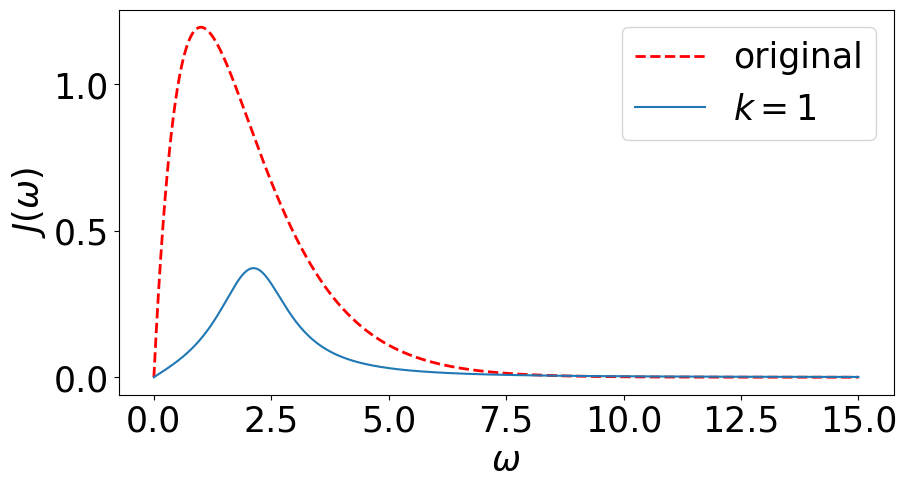

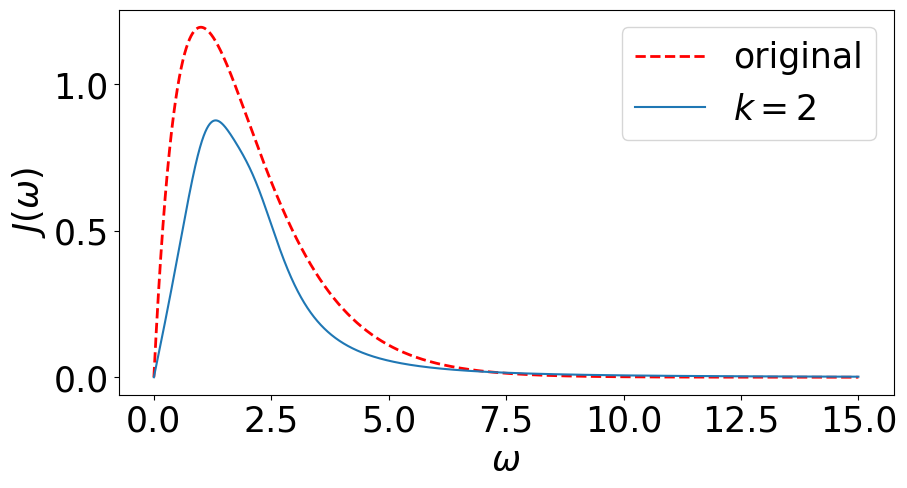

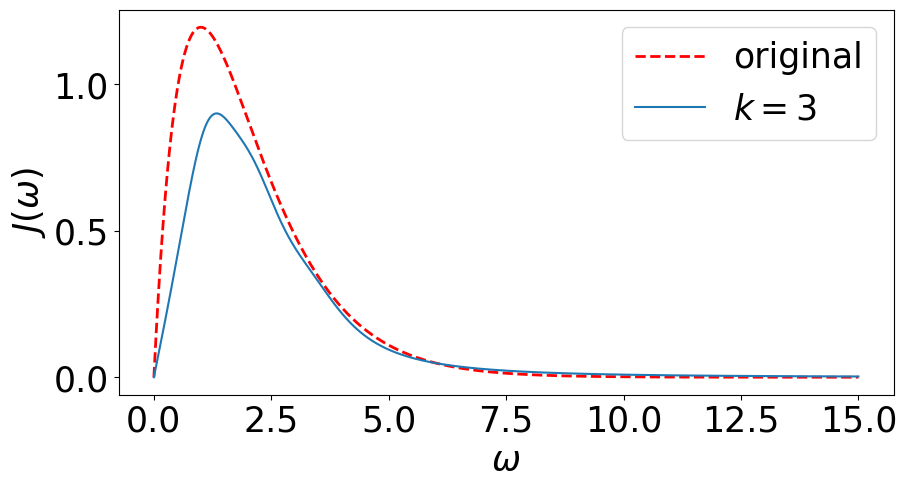

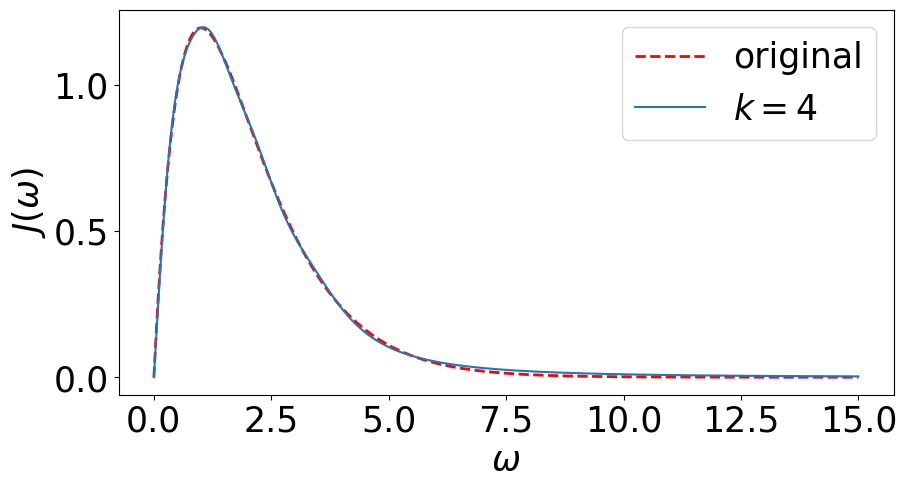

In [18]:
# Plot the components of the fit separately:
plt.rcParams["font.size"] = 25
plt.rcParams["figure.figsize"] = (10, 5)


def plot_fit(func, J, w, lam, gamma, w0):
    """Plot the individual components of a fit to the spectral density.
    and how they contribute to the full fit one by one"""
    total = 0
    for i in range(len(lam)):
        component = func(w, [lam[i]], [gamma[i]], [w0[i]])
        total += component
        plt.plot(w, J, "r--", linewidth=2, label="original")
        plt.plot(w, total, label=rf"$k={i+1}$")
        plt.xlabel(r"$\omega$")
        plt.ylabel(r"$J(\omega)$")
        plt.legend()
        plt.pause(1)
        plt.show()


def plot_fit_components(func, J, w, lam, gamma, w0):
    """Plot the individual components of a fit to the spectral density.
    and how they contribute to the full fit"""
    plt.plot(w, J, "r--", linewidth=2, label="original")
    for i in range(len(lam)):
        component = func(w, [lam[i]], [gamma[i]], [w0[i]])
        plt.plot(w, component, label=rf"$k={i+1}$")
    plt.xlabel(r"$\omega$")
    plt.ylabel(r"$J(\omega)$")
    plt.legend(bbox_to_anchor=(1.04, 1))
    plt.show()


lam, gamma, w0 = fitinfo["params"]
plot_fit(SpectralFitter._meier_tannor_SD, J, w, lam, gamma, w0)

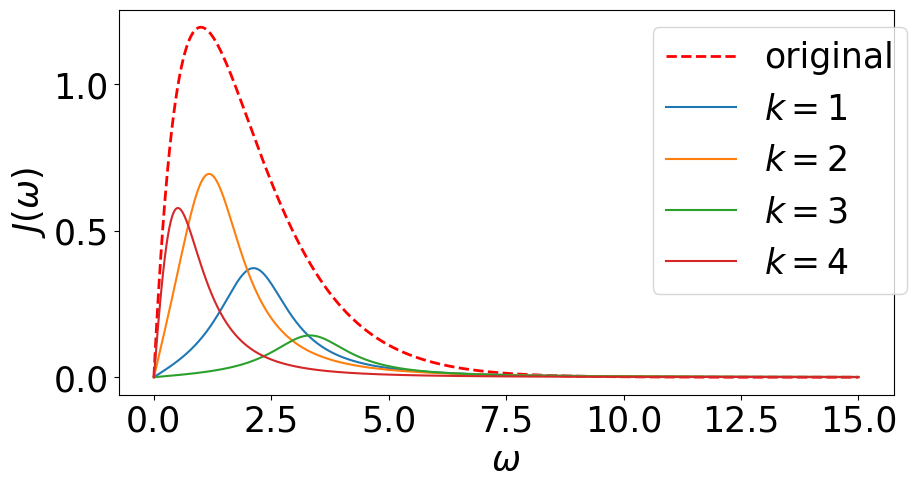

In [19]:
plot_fit_components(SpectralFitter._meier_tannor_SD, J, w, lam, gamma, w0)

And let's also compare the power spectrum of the fit and the analytical spectral density:

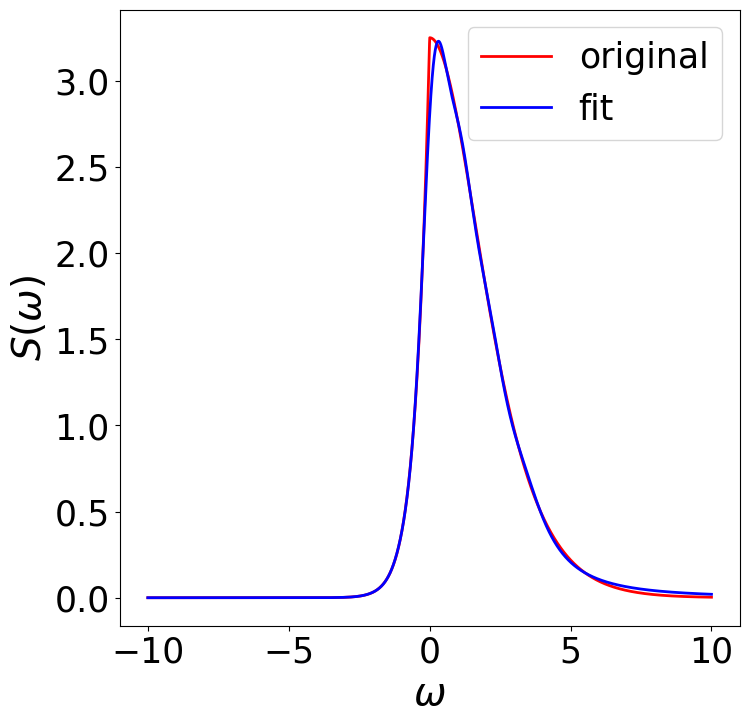

In [20]:
def plot_power_spectrum(alpha, wc, beta, save=True):
    """Plot the power spectrum of a fit against the actual power spectrum."""
    w = np.linspace(-10, 10, 50000)
    s_orig = ohmic_power_spectrum(w, alpha=alpha, wc=wc, beta=beta)
    s_fit = fittedbath.power_spectrum_approx(w)
    fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8, 8))
    axes.plot(w, s_orig, "r", linewidth=2, label="original")
    axes.plot(w, np.real(s_fit), "b", linewidth=2, label="fit")

    axes.set_xlabel(r"$\omega$", fontsize=28)
    axes.set_ylabel(r"$S(\omega)$", fontsize=28)
    axes.legend()

    if save:
        fig.savefig("powerspectrum.eps")


plot_power_spectrum(alpha, wc, 1 / T, save=False)

Now that we have a good fit to the spectral density, Let us obtain its dynamics, by passing our ``FitSpectral`` bath specifications into the ``HEOMSolver``

In [21]:
tlist = np.linspace(0, 30 * np.pi / Del, 600)
HEOM_spectral_fit = HEOMSolver(
    Hsys,
    fittedbath,
    max_depth=4,
    options=options,
)
result_spectral = HEOM_spectral_fit.run(rho0, tlist)

 [*****    23%           ] Elapsed 239.49s / Remaining 00:00:13:21

KeyboardInterrupt: 

Now if we want to see the systems's behaviour as we change the Number of terms in the fit, we may use this auxiliary function

In [ ]:
def generate_spectrum_results(Q, N, Nk, max_depth):
    """Run the HEOM with the given bath parameters and
    and return the results of the evolution.
    """
    fs = SpectralFitter(T, Q, w, J)
    bath, _ = fs.get_fit(N, Nk=Nk)
    tlist = np.linspace(0, 30 * np.pi / Del, 600)

    # This problem is a little stiff, so we use  the BDF method to solve
    # the ODE ^^^
    print(f"Starting calculations for N={N}, Nk={Nk} and max_depth={max_depth} ... ")
    HEOM_spectral_fit = HEOMSolver(
        Hsys,
        bath,
        max_depth=max_depth,
        options=options,
    )
    results_spectral_fit = HEOM_spectral_fit.run(rho0, tlist)
    return results_spectral_fit

Below we generate results for different convergence parameters (number of terms in the fit, number of matsubara terms, and depth of the hierarchy).  For the parameter choices here, we need a relatively large depth of around '11', which can be a little slow.

In [ ]:
def plot_result_expectations(plots, axes=None):
    """Plot the expectation values of operators as functions of time.

    Each plot in plots consists of (solver_result,
    measurement_operation, color, label).
    """
    if axes is None:
        fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8, 8))
        fig_created = True
    else:
        fig = None
        fig_created = False

    # add kw arguments to each plot if missing
    plots = [p if len(p) == 5 else p + ({},) for p in plots]
    for result, m_op, color, label, kw in plots:
        exp = np.real(expect(result.states, m_op))
        kw.setdefault("linewidth", 2)
        if color == "rand":
            axes.plot(
                result.times,
                exp,
                c=np.random.rand(
                    3,
                ),
                label=label,
                **kw,
            )
        else:
            axes.plot(result.times, exp, color, label=label, **kw)

    if fig_created:
        axes.legend(loc=0, fontsize=12)
        axes.set_xlabel("t", fontsize=28)

    return fig

Starting calculations for N=1, Nk=1 and max_depth=5 ... 
 [***      14%           ] Elapsed 0.19s / Remaining 00:00:00:01

 Total run time:   1.29s*] Elapsed 1.29s / Remaining 00:00:00:00
Starting calculations for N=2, Nk=1 and max_depth=5 ... 
 Total run time:   1.99s*] Elapsed 1.99s / Remaining 00:00:00:00
Starting calculations for N=3, Nk=1 and max_depth=5 ... 
 Total run time:   4.79s*] Elapsed 4.79s / Remaining 00:00:00:00
Starting calculations for N=4, Nk=1 and max_depth=5 ... 
 Total run time:  14.24s*] Elapsed 14.24s / Remaining 00:00:00:00


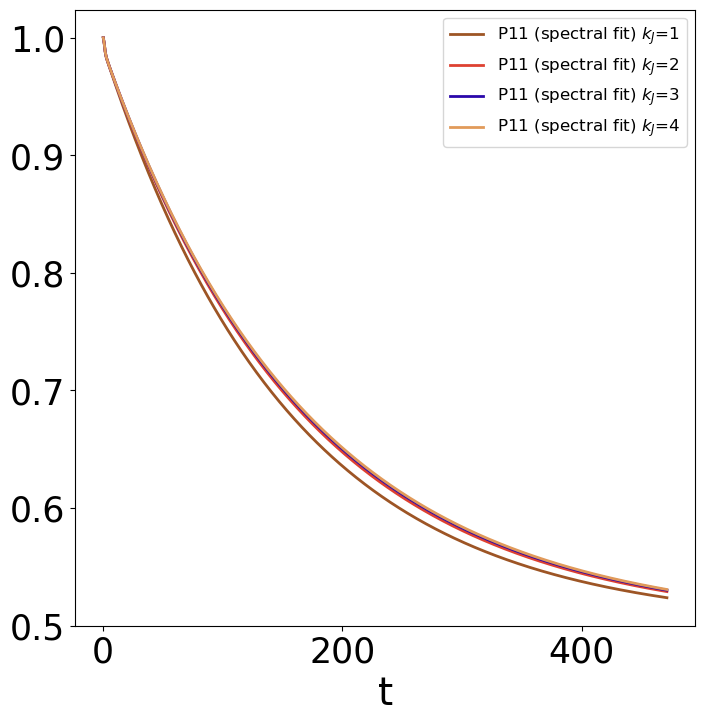

In [ ]:
# Generate results for different number of lorentzians in fit:

results_spectral_fit_pk = [
    generate_spectrum_results(Q, n, Nk=1, max_depth=max_depth) for n in range(1, 5)
]

plot_result_expectations(
    [
        (
            result,
            P11p,
            "rand",
            f"P11 (spectral fit) $k_J$={pk + 1}",
        )
        for pk, result in enumerate(results_spectral_fit_pk)
    ]
);

Starting calculations for N=4, Nk=2 and max_depth=5 ... 
 Total run time:  28.27s*] Elapsed 28.27s / Remaining 00:00:00:00
Starting calculations for N=4, Nk=3 and max_depth=5 ... 
 Total run time:  49.26s*] Elapsed 49.26s / Remaining 00:00:00:00


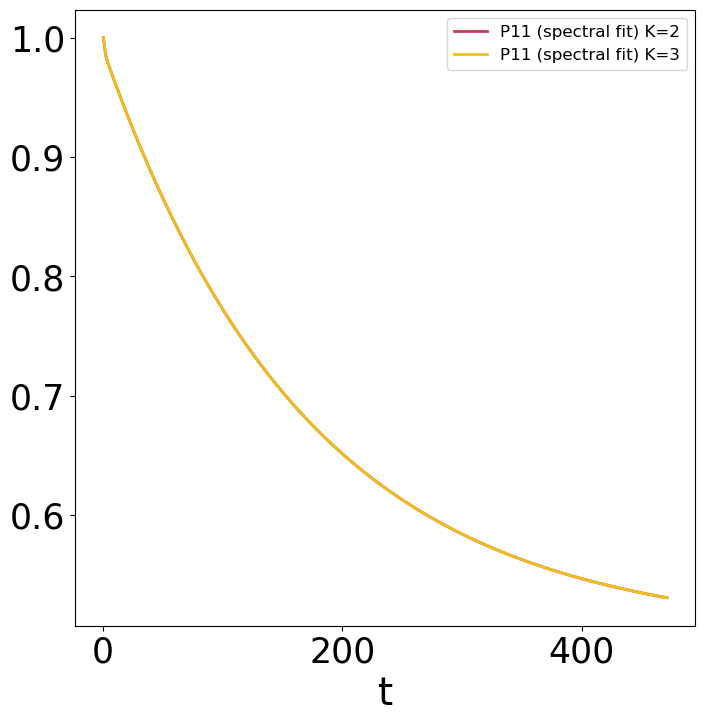

In [ ]:
#generate results for different number of Matsubara terms per Lorentzian
#for max number of Lorentzians:

Nk_list = range(2, 4)
results_spectral_fit_nk = [
    generate_spectrum_results(Q, 4, Nk=Nk, max_depth=max_depth) for Nk in Nk_list
]

plot_result_expectations(
    [
        (
            result,
            P11p,
            "rand",
            f"P11 (spectral fit) K={nk}",
        )
        for nk, result in zip(Nk_list, results_spectral_fit_nk)
    ]
);

Starting calculations for N=4, Nk=1 and max_depth=2 ... 
 Total run time:   1.08s*] Elapsed 1.08s / Remaining 00:00:00:00
Starting calculations for N=4, Nk=1 and max_depth=3 ... 
 Total run time:   1.68s*] Elapsed 1.68s / Remaining 00:00:00:00
Starting calculations for N=4, Nk=1 and max_depth=4 ... 
 Total run time:   4.80s*] Elapsed 4.80s / Remaining 00:00:00:00


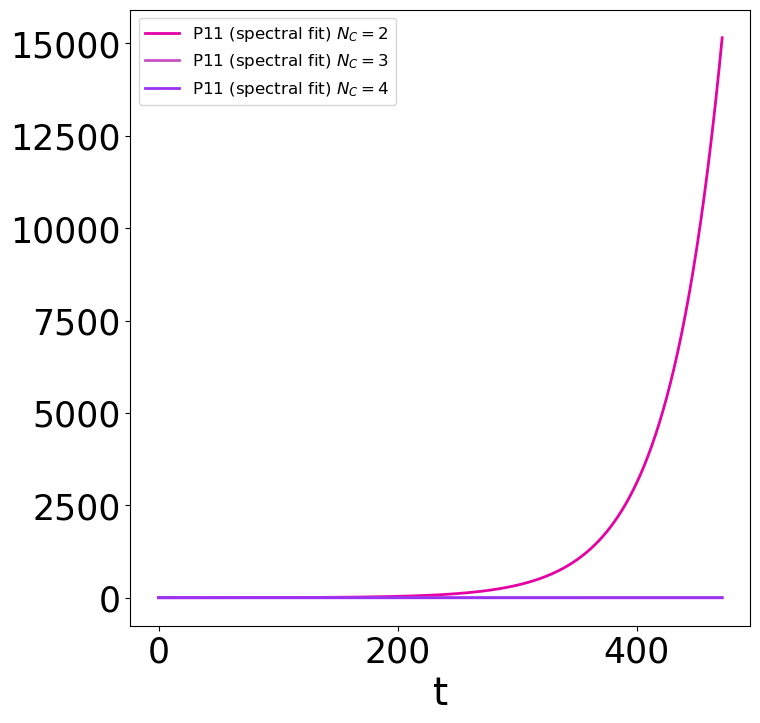

In [ ]:
# Generate results for different depths:

Nc_list = range(2, max_depth)
results_spectral_fit_nc = [
    generate_spectrum_results(Q, 4, Nk=1, max_depth=Nc) for Nc in Nc_list
]

plot_result_expectations(
    [
        (
            result,
            P11p,
            "rand",
            f"P11 (spectral fit) $N_C={nc}$",
        )
        for nc, result in zip(Nc_list, results_spectral_fit_nc)
    ]
);

#### We now combine the fitting and correlation function data into one large plot. Here we define a function to plot everything together

In [ ]:
def gen_plots(fs, w, J, t, C, w2, S):
    def plot_cr_fit_vs_actual(t, C, func, axes):
        """Plot the C_R(t) fit."""
        yR = func(t)

        axes.plot(
            t,
            np.real(C),
            "r",
            linewidth=3,
            label="Original",
        )
        axes.plot(
            t,
            np.real(yR),
            "g",
            dashes=[3, 3],
            linewidth=2,
            label="Reconstructed",
        )

        axes.set_ylabel(r"$C_R(t)$", fontsize=28)
        axes.set_xlabel(r"$t\;\omega_c$", fontsize=28)
        axes.locator_params(axis="y", nbins=4)
        axes.locator_params(axis="x", nbins=4)
        axes.text(0.15, 0.85, "(a)", fontsize=28, transform=axes.transAxes)

    def plot_ci_fit_vs_actual(t, C, func, axes):
        """Plot the C_I(t) fit."""
        yI = func(t)

        axes.plot(
            t,
            np.imag(C),
            "r",
            linewidth=3,
        )
        axes.plot(
            t,
            np.real(yI),
            "g",
            dashes=[3, 3],
            linewidth=2,
        )

        axes.set_ylabel(r"$C_I(t)$", fontsize=28)
        axes.set_xlabel(r"$t\;\omega_c$", fontsize=28)
        axes.locator_params(axis="y", nbins=4)
        axes.locator_params(axis="x", nbins=4)
        axes.text(0.80, 0.80, "(b)", fontsize=28, transform=axes.transAxes)

    def plot_jw_fit_vs_actual(w, J, axes):
        """Plot the J(w) fit."""
        J_fit = fs.spectral_density_approx(w)

        axes.plot(
            w,
            J,
            "r",
            linewidth=3,
        )
        axes.plot(
            w,
            J_fit,
            "g",
            dashes=[3, 3],
            linewidth=2,
        )

        axes.set_ylabel(r"$J(\omega)$", fontsize=28)
        axes.set_xlabel(r"$\omega/\omega_c$", fontsize=28)
        axes.locator_params(axis="y", nbins=4)
        axes.locator_params(axis="x", nbins=4)
        axes.text(0.15, 0.85, "(c)", fontsize=28, transform=axes.transAxes)

    def plot_sw_fit_vs_actual(axes):
        """Plot the S(w) fit."""

        # avoid the pole in the fit around zero:
        s_fit = fs.power_spectrum_approx(w2)

        axes.plot(w2, S, "r", linewidth=3)
        axes.plot(w2, s_fit, "g", dashes=[3, 3], linewidth=2)

        axes.set_ylabel(r"$S(\omega)$", fontsize=28)
        axes.set_xlabel(r"$\omega/\omega_c$", fontsize=28)
        axes.locator_params(axis="y", nbins=4)
        axes.locator_params(axis="x", nbins=4)
        axes.text(0.15, 0.85, "(d)", fontsize=28, transform=axes.transAxes)

    def plot_matsubara_spectrum_fit_vs_actual(t, C):
        """Plot the Matsubara fit of the spectrum ."""
        fig = plt.figure(figsize=(12, 10))
        grid = plt.GridSpec(2, 2, wspace=0.4, hspace=0.3)

        plot_cr_fit_vs_actual(
            t,
            C,
            lambda t: fs.correlation_function_approx(t),
            axes=fig.add_subplot(grid[0, 0]),
        )
        plot_ci_fit_vs_actual(
            t,
            C,
            lambda t: np.imag(fs.correlation_function_approx(t)),
            axes=fig.add_subplot(grid[0, 1]),
        )
        plot_jw_fit_vs_actual(
            w,
            J,
            axes=fig.add_subplot(grid[1, 0]),
        )
        plot_sw_fit_vs_actual(
            axes=fig.add_subplot(grid[1, 1]),
        )
        fig.legend(loc="upper center", ncol=2, fancybox=True, shadow=True)

    return plot_matsubara_spectrum_fit_vs_actual(t, C)

#### And finally plot everything together

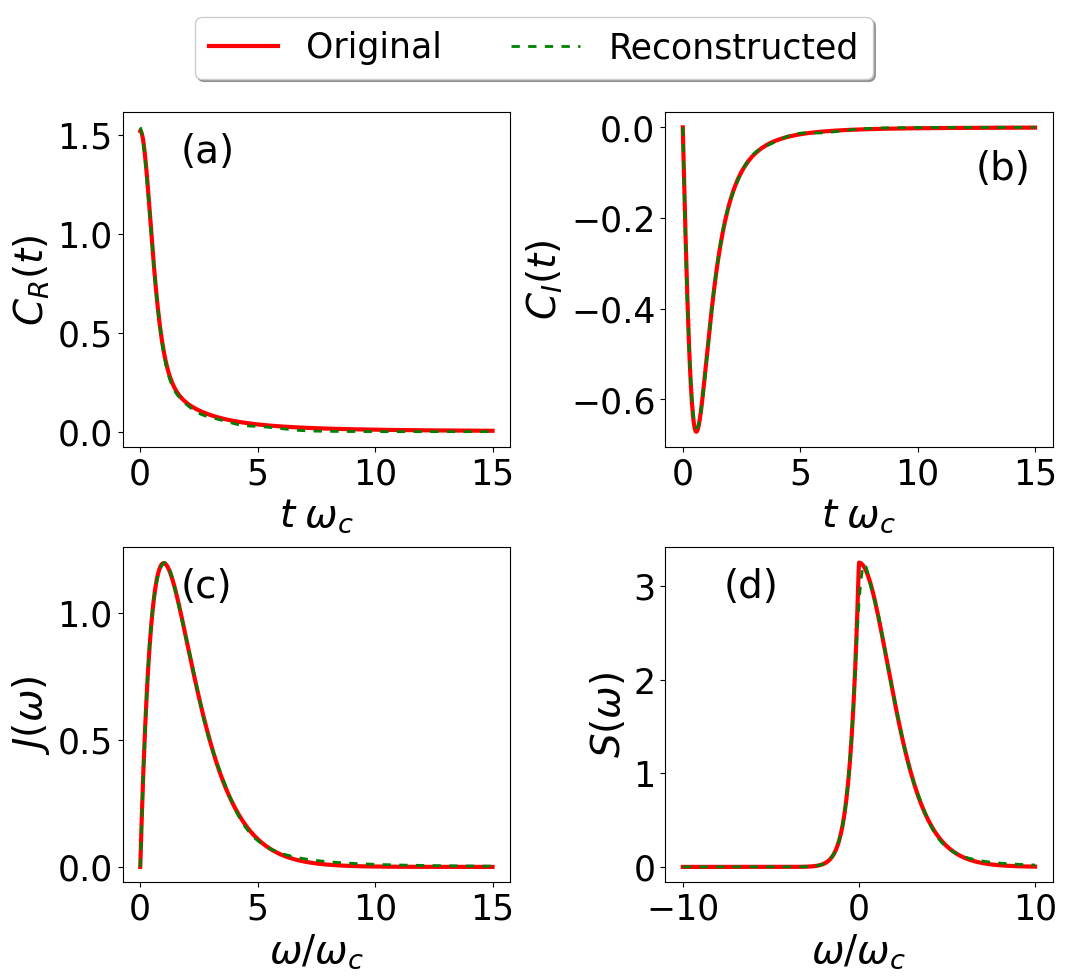

In [ ]:
t = np.linspace(0, 15, 1000)
C = ohmic_correlation(t, alpha, wc, 1 / T)
w2 = np.concatenate((-np.linspace(10, 1e-2, 100), np.linspace(1e-2, 10, 100)))
S = ohmic_power_spectrum(w2, alpha, wc, 1 / T)
gen_plots(fittedbath, w, J, t, C, w2, S)

## Building the HEOM bath by fitting the correlation function

Having successfully fitted the spectral density and used the result to calculate the Matsubara expansion and terminator for the HEOM bosonic bath, we now proceed to the second case of fitting the correlation function itself instead.

Here we fit the real and imaginary parts separately, using the following ansatz

$$C(t) = \sum_{k=1}^{n} (a_{k}+ i d_{k}) e^{-b_{k} t}e^{i c_k t}$$

Analogously to the spectral density case, one may use the `CorrelationFitter` class

In [ ]:
t = np.linspace(0, 15, 500)
C = ohmic_correlation(t, alpha=alpha, wc=wc, beta=1 / T)

In [ ]:
fc = CorrelationFitter(Q, T, t, C)

In [ ]:
bath, fitinfo = fc.get_fit(Ni=3, Nr=3)
print(fitinfo["summary"])

Fit correlation class instance: 
 
Result of fitting The Real Part Of                                      |Result of fitting The Imaginary Part                                    
 the Correlation Function with 3 terms:                                 | Of the Correlation Function with 3 terms:                              
                                                                        |                                                                        
 Parameters|    a     |    b     |    c     |    d                      | Parameters|    a     |    b     |    c     |    d                      
 1         | 1.08e-01 |-2.36e-01 || 1.13e-06 |2.76e+00                  | 1         | 1.51e+00 |-3.82e+00 || 2.00e+00 |1.94e+00                  
 2         |-6.76e+00 |-1.73e+00 ||-2.87e-01 |1.48e+01                  | 2         |-1.17e+01 |-4.49e-01 || 1.74e-08 |-1.34e-01                 
 3         | 8.15e+00 |-2.35e+00 ||-1.00e+00 |3.83e+00                  | 3         | 2.1

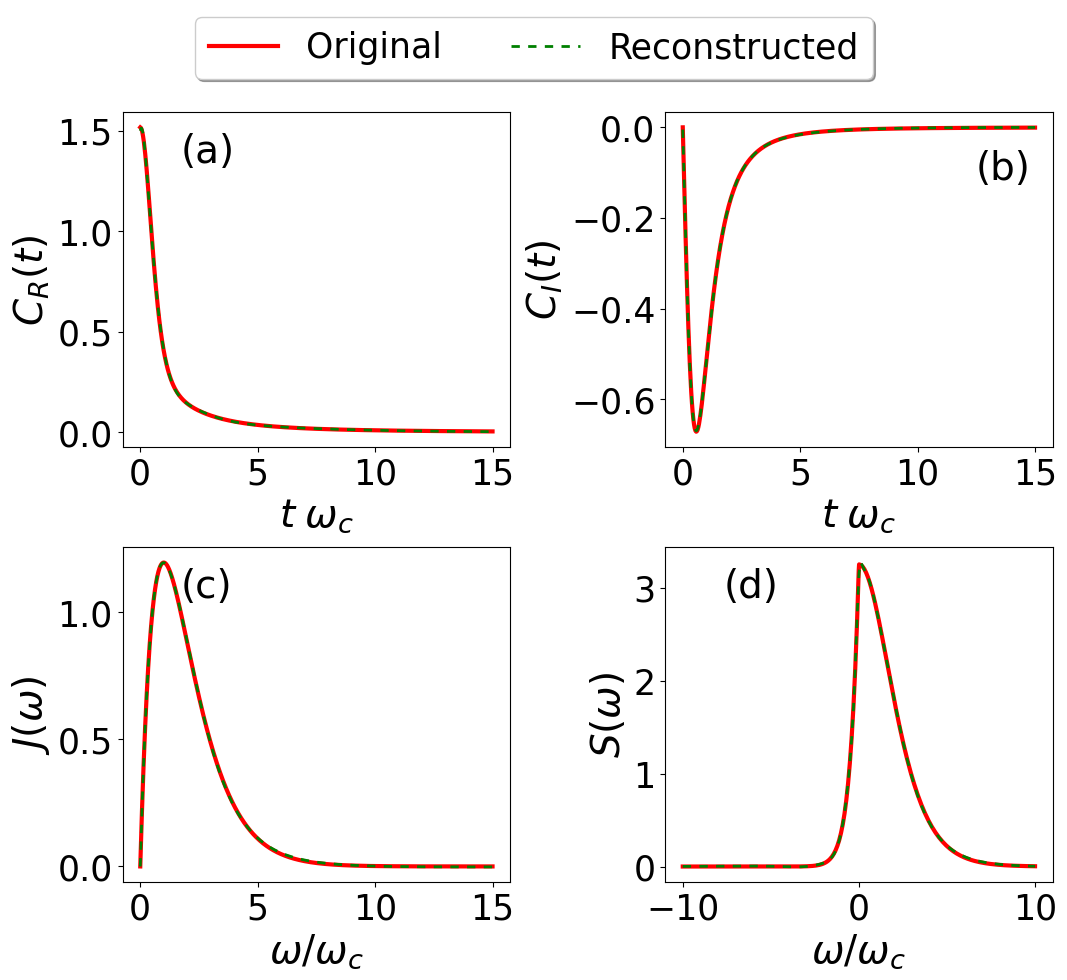

In [ ]:
gen_plots(bath, w, J, t, C, w2, S)

In [ ]:
def generate_corr_results(N, max_depth):
    tlist = np.linspace(0, 30 * np.pi / Del, 600)
    bath, _ = fc.get_fit(Ni=N, Nr=N)
    HEOM_corr_fit = HEOMSolver(
        Hsys,
        bath,
        max_depth=max_depth,
        options=options,
    )

    results_corr_fit = HEOM_corr_fit.run(rho0, tlist)

    return results_corr_fit


# Generate results for different number of exponentials in fit:
results_corr_fit_pk = [
    print(f"{i + 1}")
    or generate_corr_results(
        i,
        max_depth=max_depth,
    )
    for i in range(1, 4)
]

2
 Total run time:   1.57s*] Elapsed 1.57s / Remaining 00:00:00:00
3
 Total run time:   5.95s*] Elapsed 5.95s / Remaining 00:00:00:00
4
 Total run time:  17.48s*] Elapsed 17.47s / Remaining 00:00:00:00


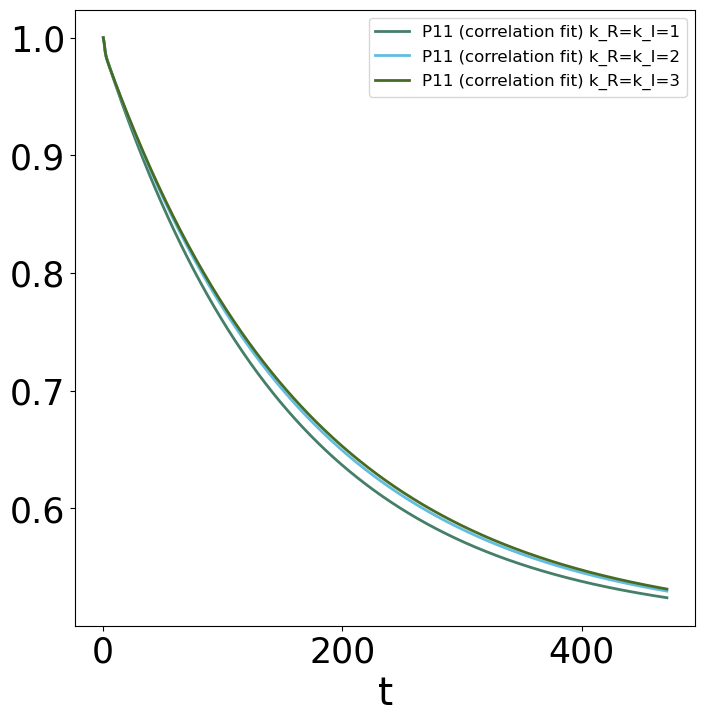

In [ ]:
plot_result_expectations(
    [
        (
            result,
            P11p,
            "rand",
            f"P11 (correlation fit) k_R=k_I={pk + 1}",
        )
        for pk, result in enumerate(results_corr_fit_pk)
    ]
);

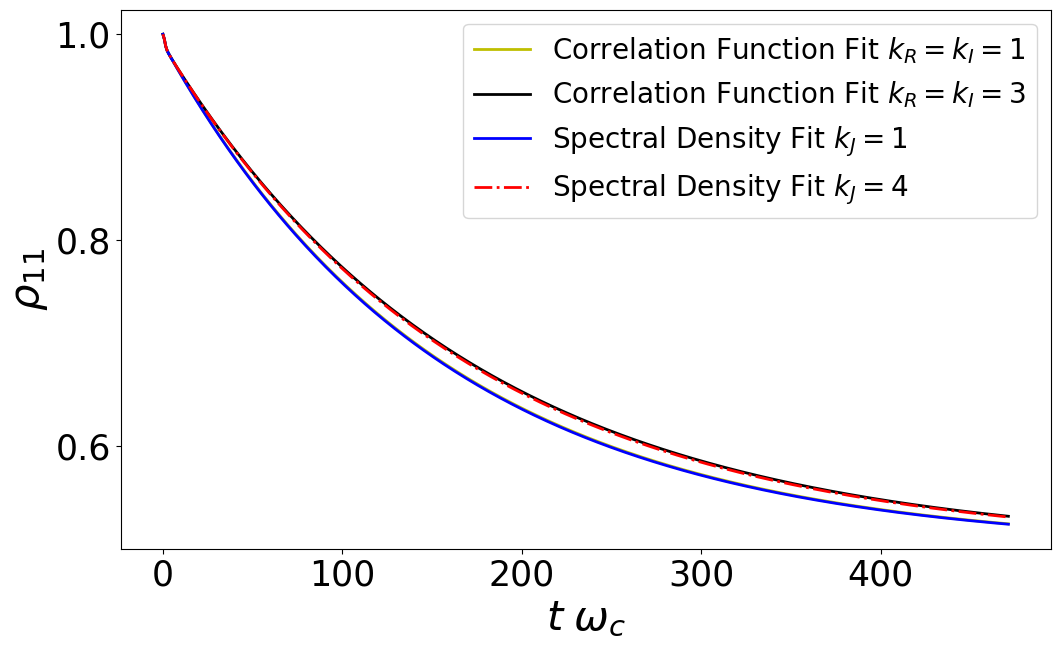

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(12, 7))

plot_result_expectations(
    [
        (
            results_corr_fit_pk[0],
            P11p,
            "y",
            "Correlation Function Fit $k_R=k_I=1$",
        ),
        (
            results_corr_fit_pk[2],
            P11p,
            "k",
            "Correlation Function Fit $k_R=k_I=3$",
        ),
        (results_spectral_fit_pk[0], P11p, "b", "Spectral Density Fit $k_J=1$"),
        (results_spectral_fit_pk[3], P11p, "r-.", "Spectral Density Fit $k_J=4$"),
    ],
    axes=axes,
)

axes.set_yticks([0.6, 0.8, 1])
axes.set_ylabel(r"$\rho_{11}$", fontsize=30)
axes.set_xlabel(r"$t\;\omega_c$", fontsize=30)
axes.legend(loc=0, fontsize=20);

# Using the Ohmic Bath class

 As the ohmic spectrum is popular in the modeling of open quantum systems, it has its own dedicated class, the results above can be reproduced quickly by using the OhmicBath class. This allows for rapid implementation of fitted ohmic baths via the correlation function or spectral density

In [ ]:
obs = OhmicBath(T, Q, alpha, wc, s)

In [ ]:
Obath, fitinfo = obs.make_correlation_fit(t, rmse=1e-4)
print(fitinfo["summary"])

Fit correlation class instance: 
 
Result of fitting The Real Part Of                                      |Result of fitting The Imaginary Part                                    
 the Correlation Function with None terms:                              | Of the Correlation Function with None terms:                           
                                                                        |                                                                        
 Parameters|    a     |    b     |    c     |    d                      | Parameters|    a     |    b     |    c     |    d                      
 1         | 1.08e-01 |-2.36e-01 || 1.13e-06 |2.76e+00                  | 1         | 1.51e+00 |-3.82e+00 || 2.00e+00 |1.94e+00                  
 2         |-6.76e+00 |-1.73e+00 ||-2.87e-01 |1.48e+01                  | 2         |-1.17e+01 |-4.49e-01 || 1.74e-08 |-1.34e-01                 
 3         | 8.15e+00 |-2.35e+00 ||-1.00e+00 |3.83e+00                  | 3         | 2.1

In [ ]:
tlist = np.linspace(0, 30 * np.pi / Del, 600)
HEOM_ohmic_corr_fit = HEOMSolver(
    Hsys,
    Obath,
    max_depth=5,
    options=options,
)
results_ohmic_corr_fit = HEOM_ohmic_corr_fit.run(rho0, tlist)

 Total run time:  19.60s*] Elapsed 19.60s / Remaining 00:00:00:00


In [ ]:
Obath, fitinfo = obs.make_spectral_fit(w, rmse=1e-4)
print(fitinfo["summary"])

Result of fitting The Spectral Density with None terms: 
 
 Parameters|   lam    |  gamma   |   w0 
 1         | 2.21e+00 | 1.25e+00 |1.00e-01
 2         | 3.27e+00 | 1.44e+00 |1.80e+00
 
A  normalized RMSE of  9.11e-05 was obtained for the The Spectral Density
 The current fit took  0.177001 seconds


In [ ]:
HEOM_ohmic_spectral_fit = HEOMSolver(
    Hsys,
    Obath,
    max_depth=5,
    options=options,
)
results_ohmic_spectral_fit = HEOM_ohmic_spectral_fit.run(rho0, tlist)

 [          1%           ] Elapsed 0.05s / Remaining 00:00:00:04

 Total run time:   2.23s*] Elapsed 2.23s / Remaining 00:00:00:00


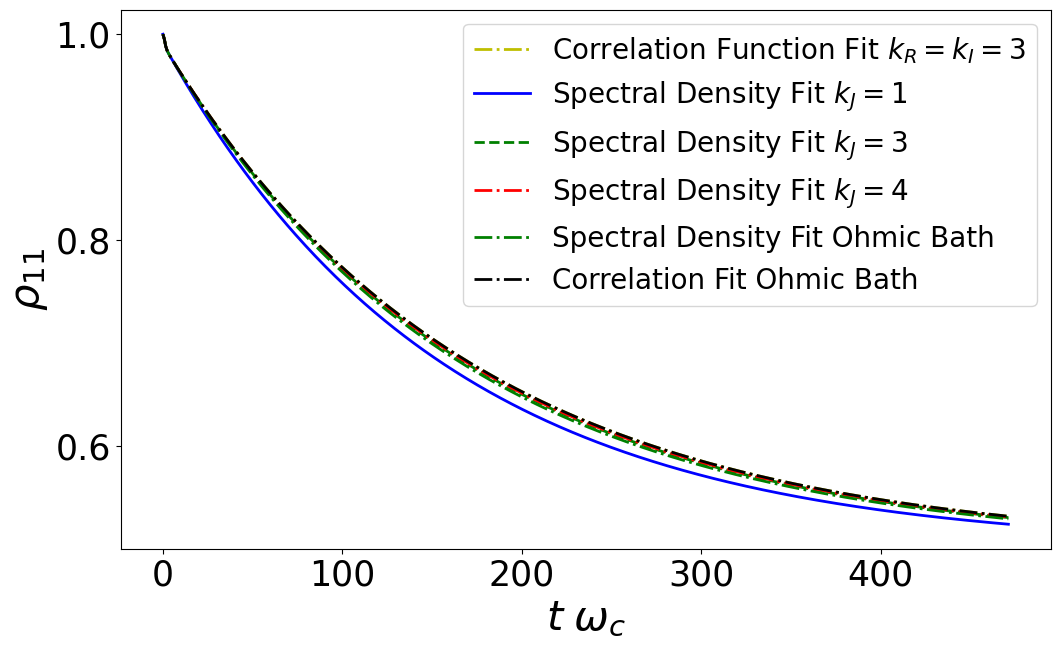

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(12, 7))

plot_result_expectations(
    [
        #   (
        #       results_corr_fit_pk[0], P11p,
        #       'y', "Correlation Function Fit $k_R=k_I=1$",
        #   ),
        (
            results_corr_fit_pk[2],
            P11p,
            "y-.",
            "Correlation Function Fit $k_R=k_I=3$",
        ),
        (results_spectral_fit_pk[0], P11p, "b", "Spectral Density Fit $k_J=1$"),
        (results_spectral_fit_pk[2], P11p, "g--", "Spectral Density Fit $k_J=3$"),
        (results_spectral_fit_pk[3], P11p, "r-.", "Spectral Density Fit $k_J=4$"),
        (results_ohmic_spectral_fit, P11p, "g-.", "Spectral Density Fit Ohmic Bath"),
        (results_ohmic_corr_fit, P11p, "k-.", "Correlation Fit Ohmic Bath"),
    ],
    axes=axes,
)

axes.set_yticks([0.6, 0.8, 1])
axes.set_ylabel(r"$\rho_{11}$", fontsize=30)
axes.set_xlabel(r"$t\;\omega_c$", fontsize=30)
axes.legend(loc=0, fontsize=20);

## About

In [ ]:
qutip.about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Jake Lishman, Simon Cross and Asier Galicia.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      5.0.0.dev0+9557c82
Numpy Version:      1.26.0
Scipy Version:      1.11.3
Cython Version:     3.0.3
Matplotlib Version: 3.8.0
Python Version:     3.12.0
Number of CPUs:     16
BLAS Info:          Generic
INTEL MKL Ext:      False
Platform Info:      Linux (x86_64)
Installation path:  /home/mcditoos/qutip_gsoc_app/qutip
Please cite QuTiP in your publication.
For your convenience a bibtex reference can be easily generated using `qutip.cite()`


## Testing

This section can include some tests to verify that the expected outputs are generated within the notebook. We put this section at the end of the notebook, so it's not interfering with the user experience. Please, define the tests using assert, so that the cell execution fails if a wrong output is generated.

In [ ]:
assert np.allclose(
    expect(P11p, results_spectral_fit_pk[2].states),
    expect(P11p, results_spectral_fit_pk[3].states),
    rtol=1e-2,
)
assert np.allclose(
    expect(P11p, results_corr_fit_pk[2].states),
    expect(P11p, results_spectral_fit_pk[3].states),
    rtol=1e-2,
)
assert np.allclose(
    expect(P11p, results_ohmic_spectral_fit.states),
    expect(P11p, results_spectral_fit_pk[3].states),
    rtol=1e-2,
)
assert np.allclose(
    expect(P11p, results_corr_fit_pk[2].states),
    expect(P11p, results_ohmic_corr_fit.states),
    rtol=1e-2,
)